In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
#import xgboost
#import optuna
import pickle
import matplotlib
#import plotly

## Data Loading

In [ ]:
! ls

In [ ]:
!mkdir data

In [ ]:
!mkdir models

In [2]:
files = [('green_tripdata_2025-06.parquet', './data'), 
         ('green_tripdata_2025-07.parquet', './data')]

print("Downloading started:...")

for file, path in files:
    url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    save_path = f"{path}/{file}"
    response = requests.get(url, stream=True)

    with open(save_path, "wb") as handle:
        for data in response.iter_content(chunk_size=1024):
            handle.write(data)
    

In [3]:
! wc -l data/green_tripdata_2025-06.parquet

    5075 data/green_tripdata_2025-06.parquet


In [4]:
! wc -l data/green_tripdata_2025-07.parquet

    4878 data/green_tripdata_2025-07.parquet


In [5]:
train_data = pd.read_parquet("data/green_tripdata_2025-06.parquet")
test_data = pd.read_parquet("data/green_tripdata_2025-07.parquet")

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49390 entries, 0 to 49389
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               49390 non-null  int32         
 1   lpep_pickup_datetime   49390 non-null  datetime64[us]
 2   lpep_dropoff_datetime  49390 non-null  datetime64[us]
 3   store_and_fwd_flag     45605 non-null  object        
 4   RatecodeID             45605 non-null  float64       
 5   PULocationID           49390 non-null  int32         
 6   DOLocationID           49390 non-null  int32         
 7   passenger_count        45605 non-null  float64       
 8   trip_distance          49390 non-null  float64       
 9   fare_amount            49390 non-null  float64       
 10  extra                  49390 non-null  float64       
 11  mta_tax                49390 non-null  float64       
 12  tip_amount             49390 non-null  float64       
 13  t

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48205 entries, 0 to 48204
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               48205 non-null  int32         
 1   lpep_pickup_datetime   48205 non-null  datetime64[us]
 2   lpep_dropoff_datetime  48205 non-null  datetime64[us]
 3   store_and_fwd_flag     43020 non-null  object        
 4   RatecodeID             43020 non-null  float64       
 5   PULocationID           48205 non-null  int32         
 6   DOLocationID           48205 non-null  int32         
 7   passenger_count        43020 non-null  float64       
 8   trip_distance          48205 non-null  float64       
 9   fare_amount            48205 non-null  float64       
 10  extra                  48205 non-null  float64       
 11  mta_tax                48205 non-null  float64       
 12  tip_amount             48205 non-null  float64       
 13  t

In [8]:
num_features = ['total_amount', 'trip_distance', 'passenger_count']
cat_features = ['PULocationID', 'DOLocationID']

In [9]:
def preprocessing(data):
    data['duration'] = data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime']
    data.duration = data.duration.apply(lambda td: td.total_seconds()/60)
    data = data[(data.duration >= 3.) & (data.duration <= 120.)] 
    data.fillna(0, inplace=True) #maybe debug this later
    return data

In [ ]:
train_tmp = preprocessing(train_data)
X_train = train_tmp[num_features + cat_features]
y_train = train_tmp['duration']

In [ ]:
X_test = preprocessing(test_data)[num_features + cat_features]
y_test = preprocessing(test_data)['duration']

<Axes: >

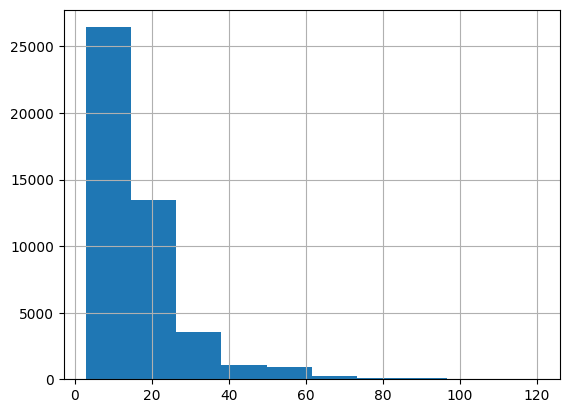

In [12]:
train_tmp.duration.hist()

<Axes: >

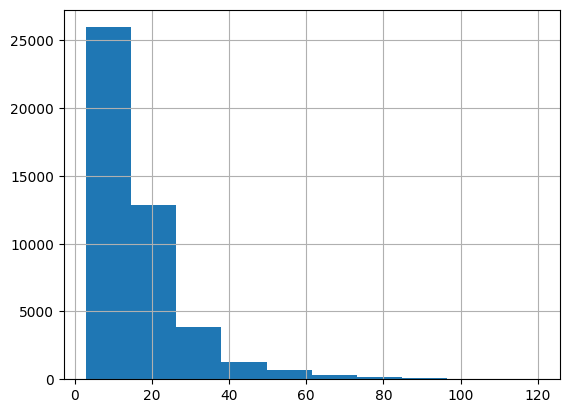

In [14]:
y_test.hist()

In [17]:
y_test.mean()

np.float64(16.630611433744782)

In [18]:
y_test.median()

np.float64(13.15)

In [19]:
y_test.std()

np.float64(12.464207942502515)

## Baseline model

In [15]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [16]:
train_pred = model.predict(X_train)
root_mean_squared_error(train_pred, y_train)

8.808917688232455

In [ ]:
train_tmp.duration.hist()

In [ ]:
matplotlib.pyplot.hist(train_pred)

In [ ]:
train_pred

In [20]:
test_pred = model.predict(X_test)
root_mean_squared_error(test_pred, y_test)

9.03071796594986

In [21]:
with open("models/nyc_green_txi_lin_reg.pkl", "wb") as f_out:
    pickle.dump(model, f_out)

In [22]:
! ls models

lin_reg.pkl               nyc_green_txi_lin_reg.pkl


## Experiments

In [23]:
import mlflow

In [24]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")

In [25]:
mlflow.set_experiment("nyc taxi: simple experiment")

2025/08/26 17:24:01 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/26 17:24:01 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/08/26 17:24:01 INFO mlflow.tracking.fluent: Experiment with name 'nyc taxi: simple experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/emelidral/Dev/a_experiments_2025/mlruns/3', creation_time=1756225441362, experiment_id='3', last_update_time=1756225441362, lifecycle_stage='active', name='nyc taxi: simple experiment', tags={}>

In [ ]:
?Lasso

In [27]:
with mlflow.start_run():
    alpha=0.5
    model = Lasso(alpha)
    mlflow.log_param("alpha", alpha)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, test_pred)
    mlflow.log_metric("rmse", rmse)
    mlflow.set_tag("workspace", "classwork")

In [29]:
with mlflow.start_run():
    alpha=0.5
    model = Lasso(alpha)
    mlflow.log_param("alpha", alpha)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, test_pred)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_artifact("data/green_tripdata_2025-06.parquet")
    mlflow.log_artifact("data/green_tripdata_2025-07.parquet")
    mlflow.sklearn.log_model(model) #, input_example=)
    mlflow.set_tag("workspace", "classwork")

2025/08/26 17:33:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Auto logging

In [ ]:
mlflow.sklearn.autolog()
alpha=0.2
model = Lasso(alpha)
model.fit(X_train, y_train)

In [ ]:
mlflow.sklearn.autolog()
alpha=0.7
model = Lasso(alpha)
model.fit(X_train, y_train)
test_preds = model.predict(X_test)
mlflow.log_metric("rmse", root_mean_squared_error(y_test, test_pred))
mlflow.end_run()

In [34]:
mlflow.set_experiment("nyc taxi: lasso alpha")

2025/08/26 17:47:14 INFO mlflow.tracking.fluent: Experiment with name 'nyc taxi: lasso alpha' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/emelidral/Dev/a_experiments_2025/mlruns/4', creation_time=1756226834461, experiment_id='4', last_update_time=1756226834461, lifecycle_stage='active', name='nyc taxi: lasso alpha', tags={}>

In [ ]:
with mlflow.start_run():
    for alpha in range(0, 100, 5):
        with mlflow.start_run(nested=True):
            model = Lasso(alpha/100)
            mlflow.log_param("alpha", alpha/100)
            model.fit(X_train, y_train)
            test_preds = model.predict(X_test)
            rmse = root_mean_squared_error(y_test, test_pred)
            mlflow.log_metric("rmse", rmse)

mlflow.end_run()

In [40]:
mlflow.end_run()

In [36]:
max_depth = [3, 5, 7, 10]
n_trees = [10, 20, 50, 100]

In [42]:
params = zip(max_depth, n_trees)

In [38]:
for i in params:
    print(i)

(3, 10)
(5, 20)
(7, 50)
(10, 100)


In [ ]:
with mlflow.start_run(run_name="RandomForestRegressor"):
    for param in params:
        with mlflow.start_run(nested=True, run_name=f"max_depth={param[0]};n_estimators={param[1]}"):
            model = RandomForestRegressor(random_state=42, max_depth=param[0], n_estimators=param[1])
            mlflow.log_param("max_depth", param[0])
            mlflow.log_param("n_estimators", param[1])
            model.fit(X_train, y_train)
            test_preds = model.predict(X_test)
            rmse = root_mean_squared_error(y_test, test_pred)
            mlflow.log_metric("rmse", rmse)

In [ ]:
mlflow.xgboost.autolog()

In [ ]:
mlflow.catboost

In [ ]:
mlflow.pytorch

## Model run

In [ ]:
run_id = "YOUR RUN ID HERE"

In [ ]:
logged_model = mlflow.pyfunc.load_model(run_id)

In [ ]:
type(logged_model)

In [ ]:
logged_model.predict(X_test.loc[:1])